## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [6]:
converted = df.query("converted == 1")
converted.shape[0]
proportion = converted.shape[0]/df.shape[0]
proportion

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
line_up = df.query('landing_page == "new_page" and group == "control"').shape[0]
line_up2 = df.query('landing_page == "old_page" and group == "treatment"').shape[0]
line_up+line_up2

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
dfa = df.query('landing_page == "new_page" and group == "treatment"')
dfb = df.query('landing_page == "old_page" and group == "control"')
df2= dfa.append(dfb)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893, inplace = True)

In [15]:
df2.user_id.duplicated().sum()

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
p1 = df2.query('converted == 1').shape[0]/df2.shape[0]
p1

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p2 = df2.query('converted == 1 and group =="control"').shape[0]/df2.query('group == "control"').shape[0]
p2

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p3 = df2.query('converted == 1 and group =="treatment"').shape[0]/df2.query('group == "treatment"').shape[0]
p3

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
p4 = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
p4

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**NO, there is no sufficient evidence to suggest the new treatment page leads to more conversions. Although the old page led the conversion probability, but it is not significant**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0:Pold >= Pnew 

H1:Pnew > Pold

or...

H0:Pold − Pnew >= 0

H1:Pnew−Pold > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_null = df2.converted.mean()
p_new= p_null
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = p_null
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice(2,p = [1-p_new, p_new],size = n_new)
new_page_converted.mean()

0.11851214644553025

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice(2,p= [1-p_old, p_old], size= n_old)
old_page_converted.mean()

0.11836942605008467

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00014272039544557802

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
p_diffs = []
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
p_diffs = new_page_converted- old_page_converted


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

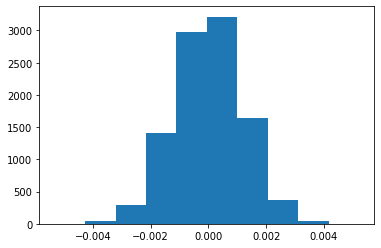

In [32]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

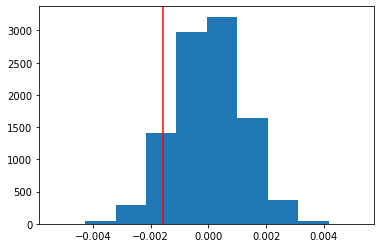

In [33]:
act_diff = p3 - p2

plt.hist(p_diffs);
plt.axvline(act_diff, color='red');

In [34]:
#calculating the p_value

p_value = (p_diffs > act_diff).mean()
p_value

0.9049

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated is the p_value and it is based on the alternative. Since the p_value is greater than the Type I error rate, we will fail to reject the null hypothesis and can infer that the old page is better than the new page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
pip install statsmodels

     ---------------------------------------- 9.1/9.1 MB 79.1 kB/s eta 0:00:00
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 21.2
    Uninstalling packaging-21.2:
      Successfully uninstalled packaging-21.2
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\isooasoleymi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [35]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score tells that the statistic is 1.31 standard deviation above mean. The p_value shows the propability of the alternative hypothesis. Yes, the values agree with the previous calculations in j and k**

### A/B Test Conclusion

**Based on the outcome of the concluded test, it could be inferred that proportion of conversion for the new page is not better than that of the old page. The company is then advised to keep the old page**

**From a practical perspective, to avoid possible user visits decline due to change of the page, the company is advised to keep the old page since there is no statistical evidence to support the new page will perform better**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#creating the intercept column
df2['intercept'] = 1
#creating the dummy columns
df2[['a_page', 'ab_page']] = pd.get_dummies(df2['landing_page'])
#dropping the a_page column as it serves same purpose as the ab_page column
df2.drop('a_page', axis=1, inplace = True)
df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
5513,674945,2017-01-11 09:00:02.489994,treatment,new_page,0,1,0
109912,714859,2017-01-21 04:12:11.939858,treatment,new_page,0,1,0
14789,814967,2017-01-06 10:28:46.666537,treatment,new_page,0,1,0
112599,694546,2017-01-18 14:59:52.621501,treatment,new_page,0,1,0
165914,710376,2017-01-07 17:09:08.851480,treatment,new_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 May 2022   Pseudo R-squ.:               8.077e-06
Time:                        15:22:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with the ab_page is 0.190.**

**The values differ because the test in Part II is a one tailed test while the regression test is two-tailed. This can be explained as since the p-value for the ab_page is high, it means the landing page does not determine the conversion rate implying that pnew = pold, which is a two tailed test**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**I believe it is a good idea to add additional considerations to the regression model. It further coroborates the fact that the pages does not have significant impact on if a user converts or not**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0


In [41]:
### Create the necessary dummy variables
df_new['country'].unique()
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.drop('CA', axis = 1, inplace = True)
df_new.sample(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
934062,US,2017-01-22 02:48:06.648453,treatment,new_page,0,1,0,0,1
830690,UK,2017-01-08 10:06:29.802789,control,old_page,0,1,1,1,0
663122,UK,2017-01-02 23:21:40.228027,control,old_page,0,1,1,1,0
747548,US,2017-01-06 19:16:37.309018,control,old_page,0,1,1,0,1
903633,US,2017-01-20 13:12:51.547128,treatment,new_page,1,1,0,0,1


In [53]:
df_new.sample(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
862951,US,2017-01-12 18:23:22.118380,treatment,new_page,0,1,0,0,1
822995,US,2017-01-05 22:42:36.057698,control,old_page,0,1,1,0,1
937468,UK,2017-01-17 15:35:48.046933,control,old_page,0,1,1,1,0
936822,US,2017-01-06 23:59:09.432913,treatment,new_page,0,1,0,0,1
911061,US,2017-01-21 15:47:06.734092,treatment,new_page,1,1,0,0,1


In [42]:
#creating interactions column
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']


In [55]:
df_new.sample(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
677284,US,2017-01-08 08:03:53.379391,control,old_page,0,1,1,0,1,0,1
658473,US,2017-01-15 00:18:00.237605,treatment,new_page,0,1,0,0,1,0,0
901991,UK,2017-01-10 10:44:11.778928,treatment,new_page,0,1,0,1,0,0,0
714580,US,2017-01-12 10:29:41.065341,control,old_page,0,1,1,0,1,0,1
686207,UK,2017-01-14 20:13:49.752520,control,old_page,0,1,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
### Fit Your Linear Model And Obtain the Results
lm1 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK', 'US','UK_ab_page', 'US_ab_page']])
results1 = lm1.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 May 2022   Pseudo R-squ.:               3.482e-05
Time:                        15:22:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0715      0.037    -55.798      0.000      -2.144      -1.999
ab_page        0.0674      0.052      1.297      0.195      -0.034       0.169
UK             0.0901      0.040      2.225      0.026       0.011       0.169
US             0.0644      0.038      1.679      0.093      -0.011       0.140
UK_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

**Conclusion: Based on the p-value of the UK_ab_page and US_ab_page, there is no sufficient evidence to suggest that the countries have significant impact on the conversation rate for the pages**

**Maintaining a Type I error rate of 5%, It is clear from the p-value of both nations considered independently that there is no evidence to suggest that a country influences the conversion of users**

<a id='conclusions'></a>
## Conclusions

Based on the outcomes of the AB Test and the Regression analysis. The following can be concluded:

Statistically: There is no evidence that suggests that the proportions of conversions from the new page is better than that of the old page. Also, there is evidence that suggests that conversion proportions is independent of the type of page available to the user.

Practically: Other features of the page in terms of cost to company amongst other things can be used to select the final page to make available to users

